# 倒立振子のシミュレーションを Julia で行いたい

## はじめに

### 倒立振子とは

台車の上に棒が立っていて，その棒が倒れないようにしつつ台車を動かすという制御問題のことを倒立振子（とうりつしんし，inverted pendulum）といいます．

制御や強化学習の界隈の Hello World としてよく親しまれている問題です．倒立振子のシミュレーションを自分で組むと勉強になるとされています．

### Julia とは

主に科学計算の世界で使われている比較的新しい言語です．Python や Matlab を使ってもいいのですが，今回は Julia を使います．

## 倒立振子の運動方程式

シミュレーションをするには，運動方程式がわかっている必要があります．

運動方程式の導出は物理学の問題であって，制御の問題ではないのでここでは詳しくは述べません．[Excelで学ぶ振動基礎/運動方程式の立て方](https://edu.katzlab.jp/lec/vib7h/files/vib7h_B.pdf)に解析力学を使って導出する方法が解説されているので，そちらを参照してください．

ここでは以下のようなパラメータを考えます．

* 定数
  * 台車の質量 $M$ [kg]
  * 振子の質量 $m$ [kg]
  * 重力加速度 $g$ [m/s^2]
  * 台車から振子の重心までの距離 $l$ [m]

* 変数
  * 台車の位置 $x$ [m]
  * 振子の傾き $θ$ [rad]. 垂直に立っている状態がゼロ．
  * 外力 $f$ [N] (制御入力 $u$ に相当する)

摩擦や空気抵抗は考えないものとしています．

このとき，結論だけ書いてしまうと，運動方程式は次の通りです．
$$
(M + m) \ddot{x} + m l \ddot{θ} \cos θ - m l \dot{θ}^2 \sin θ = f \\\\
(ml \cos θ) \ddot{x} + ml^2 \ddot{θ} - mgl \sin θ = 0
$$

## 状態方程式を求める

さらにこれを状態空間モデルとして解釈するために，状態ベクトル $X$ を考えます．状態は $x, \dot{x}, θ, \dot{θ}$ の 4 つなので
$$
X = \begin{bmatrix} x \\ \dot{x} \\ θ \\ \dot{θ} \end{bmatrix}
$$
とします．

$X$ の微分を $X$ と $f$ で表現する必要があります．これの計算はそれなりに面倒なので，Julia の `Symbolics` パッケージを使用して計算します．

In [35]:
using Symbolics

# 変数を宣言する
@variables t f m l M x θ g

# 時間 t に対する微分作用素
D = Differential(t)

# 2回微分
DD = D ∘ D

# 2つの運動方程式を定義する
eq_1 = (M + m) * DD(x) + m * l * cos(θ) * DD(θ) - m * l * (D(θ))^2 * sin(θ) - f
eq_2 = m * l * cos(θ) * DD(x) + m * l^2 * DD(θ) - m * g * l * sin(θ)

display(eq_1)
display(eq_2)


-f + (M + m)*Differential(t)(Differential(t)(x)) + l*m*cos(θ)*Differential(t)(Differential(t)(θ)) - l*m*(Differential(t)(θ)^2)*sin(θ)

-g*l*m*sin(θ) + (l^2)*m*Differential(t)(Differential(t)(θ)) + l*m*cos(θ)*Differential(t)(Differential(t)(x))

In [36]:
begin
    # x の２階微分を消去する
    eq_without_DDx = (m * l * cos(θ)) * eq_1 - (M + m) * eq_2 |> z->simplify(z,expand=true)
    display(eq_without_DDx)

    # θ の２階微分を表示する式を求める
    DDθ = Symbolics.solve_for(eq_without_DDx, DD(θ)) |> simplify
    display(DDθ)
end

-f*l*m*cos(θ) + M*g*l*m*sin(θ) - M*(l^2)*m*Differential(t)(Differential(t)(θ)) + g*l*(m^2)*sin(θ) - (l^2)*(m^2)*Differential(t)(Differential(t)(θ)) + (l^2)*(m^2)*(cos(θ)^2)*Differential(t)(Differential(t)(θ)) - (1//2)*(l^2)*(m^2)*sin(2θ)*(Differential(t)(θ)^2)

(f*cos(θ) - M*g*sin(θ) - g*m*sin(θ) + (1//2)*l*m*sin(2θ)*(Differential(t)(θ)^2)) / (-M*l - l*m + l*m*(cos(θ)^2))

In [37]:
begin
    # θ の２階微分を消去する
    eq_without_DDθ = l * eq_1 - cos(θ) * eq_2 |> z->simplify(z,expand=true)
    display(eq_without_DDθ)

    # x の２階微分を表示する式を求める
    DDx = Symbolics.solve_for(eq_without_DDθ, DD(x)) |> simplify
end

-f*l + M*l*Differential(t)(Differential(t)(x)) + l*m*Differential(t)(Differential(t)(x)) + (1//2)*g*l*m*sin(2θ) - l*m*(cos(θ)^2)*Differential(t)(Differential(t)(x)) - (l^2)*m*(Differential(t)(θ)^2)*sin(θ)

(f - (1//2)*g*m*sin(2θ) + l*m*(Differential(t)(θ)^2)*sin(θ)) / (M + m - m*(cos(θ)^2))

## Julia でシミュレーションを行う

Julia でシミュレーションを行うために，

* 各時刻において状態と制御入力から状態の微分を求める関数
* ある時刻における状態と制御入力から， ある微小な時間 `dt` だけ経過したときの状態を求める関数

が必要です．

In [48]:
"""台車と振子の状態"""
struct State
    x::Float64 # 台車の位置 [m]
    θ::Float64 # 振子の角度 [rad]
    v::Float64 # 台車の速度 [m/s]
    ω::Float64 # 振子の角速度 [rad/s]
end

"""状態の微分"""
struct StateDeriv
    v::Float64
    ω::Float64
    x_acc::Float64 # 台車の加速度 [m/s^2]
    θ_acc::Float64 # 振子の角加速度 [rad/s^2]
end

"""
系の状態と制御入力から，状態の微分を計算する関数．
`X' = f(X, u)` を満たす．

## Arguments
* `X::State` : 現在の状態
* `u::Float64` : 制御入力
"""
function cartpole(X :: State, u :: Float64) :: StateDeriv
    x, θ, v, ω = X.x, X.θ, X.v, X.ω

    g = 9.8 # 重力加速度 [m/s^2]
    mc = 1.0 # 台車の質量 [kg]
    mp = 0.2 # 振子の質量 [kg]
    l = 0.5 # 台車から振子の重心までの長さ [m]

    x_acc = (u - 0.5 * g * mp * sin(2 * θ) + mp * l * ω^2 * sin(θ)) / (mc + mp * sin(θ)^2)
    θ_acc = (u * cos(θ) - mc * g * sin(θ) - g * mp * sin(θ) + 0.5 * mp * l * ω^2 * sin(2 * θ) ) / (-l * (mc + mp * sin(θ)^2))

    return StateDeriv(v, ω, x_acc, θ_acc)
end

cartpole

シミュレーションの実行方法ですが，常微分方程式 `X' = f(X, u)` を何らかの方法で解いて，その結果をプロットする必要があります．厳密に解くのは難しいため，近似的に解きます．ここでは[Euler法](https://ja.wikipedia.org/wiki/%E3%82%AA%E3%82%A4%E3%83%A9%E3%83%BC%E6%B3%95)を使用します．

Simulation terminated: θ exceeded π/2


┌ Info: Saved animation to /home/aseiinoue/julia-inverted-pendulum/image/cartpole_simulation.gif
└ @ Plots /home/aseiinoue/.julia/packages/Plots/a3u1v/src/animation.jl:156


Plots.AnimatedGif("/home/aseiinoue/julia-inverted-pendulum/image/cartpole_simulation.gif")
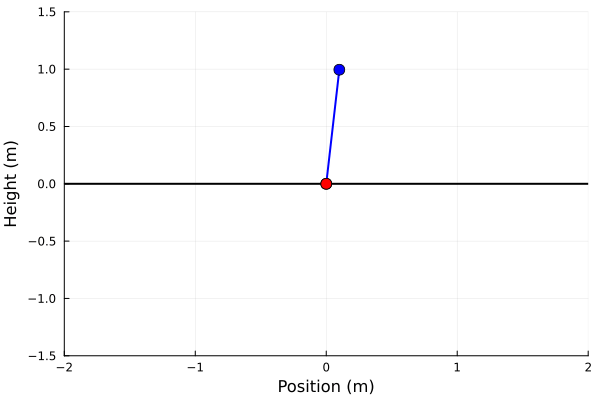

In [55]:
"""
Euler法を使用して微分方程式を数値的に解く関数.

## Arguments
* `f` : 状態の微分を計算する関数
* `X0` : 初期状態
* `u_func` : 各時刻に対して制御入力を返す関数
* `dt` : タイムステップ
* `T` : シミュレーションの時間

## Returns
* `X` : シミュレーション中の状態の配列
"""
function simulate_euler(f::Function, X0::State, u_func::Function, dt::Float64, T::Float64) :: Vector{State}
    num_steps = Int(T / dt) # タイムステップの数
    X = [X0] # 状態の配列を初期化
    current_X = X0 # 現在の状態を初期状態に設定
    t = 0.0 # 時刻を初期化

    for i in 1:num_steps
        u = u_func(t) # 制御入力を計算

        # Euler法に基づいて次の状態を計算
        next_X = State(
            current_X.x + current_X.v * dt,
            current_X.θ + current_X.ω * dt,
            current_X.v + f(current_X, u).x_acc * dt,
            current_X.ω + f(current_X, u).θ_acc * dt
        )

        # 振子が倒れていたらシミュレーションを終了する
        if abs(next_X.θ) >= π/2
            println("Simulation terminated: θ exceeded π/2")
            break
        end
        append!(X, [next_X]) # 次の状態を配列に追加
        current_X = next_X # 現在の状態を更新
        t += dt # 時刻を更新
    end

    return X
end

# 初期状態
const X0 = State(0.0, 0.1, 0.0, 0.0)

# タイムステップとシミュレーション時間
const dt = 0.01
const T = 10.0

# 制御入力を定義
function control_input(t)
    return 0.0
end

# Euler法でシミュレーションを実行
simulated_states = simulate_euler(cartpole, X0, control_input, dt, T)

# シミュレーション結果のプロットに必要なパッケージを宣言
using Plots

# アニメーションとしてプロット
anim = @animate for state in simulated_states
    cart_x = state.x
    pendulum_x = cart_x + sin(state.θ)
    pendulum_y = cos(state.θ)

    plot([-2, 2], [0, 0], color=:black, lw=2, xlim=(-2, 2), ylim=(-1.5, 1.5), legend=false, xlabel="Position (m)", ylabel="Height (m)")
    plot!([cart_x, pendulum_x], [0, pendulum_y], color=:blue, lw=2, marker=:circle, markersize=6, label="Pendulum")
    scatter!([cart_x], [0], color=:red, markersize=6, label="Cart")
end

# アニメーションを表示
gif(anim, "image/cartpole_simulation.gif", fps = 30)
